# Modulação DDO-CE-OFDM

Este código apresenta uma implementação de um sistema de comunicação óptica de detecção direta com modulação OFDM e envelope constante (DDO-CE-OFDM). 

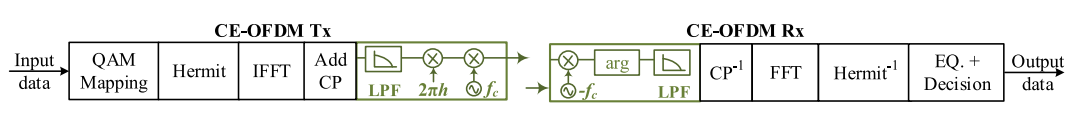

In [179]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.random      import normal

from commpy.utilities  import upsample
from tqdm.notebook     import tqdm
from utils.dsp         import highPassFIR

from scipy.fft         import fft, ifft, fftshift, fftfreq
from scipy.constants   import c, h, e, k, pi
from scipy.signal      import hilbert
from scipy.interpolate import interp1d

from optic.modulation  import modulateGray, demodulateGray, GrayMapping
from optic.dsp         import pulseShape, lowPassFIR, firFilter, finddelay
from optic.metrics     import signal_power, fastBERcalc
from optic.core        import parameters
from optic.models      import mzm, ssfm

In [180]:
font = {'family':'serif', 'weight':'normal', 'size':16}
plt.rc('font', **font)
plt.rc('lines',lw = 2)

In [181]:
def modulateOFDM(N, G, symbTx):
    symbTx_P = np.zeros((int(len(symbTx)/(N/2)), N + G), complex)
    aux = 0

    for i in range(len(symbTx_P)):
        symbTx_P[i,G:G+int(N/2)] = symbTx[int(aux):int(aux+N/2)]
        aux = aux + N/2
        
        # Simetria hermitiana
        v = symbTx_P[i,G]
        symbTx_P[i,G] = v.real
        symbTx_P[i,G + int(N/2)] = v.imag 

        for j in range(int(N/2)-1):
            j = j + 1
            symbTx_P[i,G + int(N) - j] = np.conjugate(symbTx_P[i,G + j])
        
        # Aplicação da IFFT
        symbTx_P[i,G:N+G] = ifft(symbTx_P[i,G:N+G])*np.sqrt(N)

        # Adição do prefixo cíclico
        symbTx_P[i,:] = np.concatenate((symbTx_P[i,N:N+G],symbTx_P[i,G:N+G]))
    
    # Conversão Paralelo -> Serial
    symbTx_OFDM = np.squeeze(symbTx_P.reshape(1,len(symbTx_P[0])*len(symbTx_P)))
    
    return symbTx_OFDM

In [200]:
def demodulateOFDM(N, G, K, pilot, symbRx_OFDM):
    Int = int((N/2)/K) 
    carriers       = np.arange(0, int(N/2), 1)
    pilot_carriers = carriers[1::Int]
    
    # Conversão S/P
    symbRx_P = np.zeros((int(len(symbRx_OFDM)/(N+G)), N), complex)
    aux = 0
    
    for i in range(len(symbRx_P)):
        # Extração do prefixo cíclico
        symbRx_P[i,0:N] = symbRx_OFDM[aux+G:aux+N+G]
        aux = aux + N + G

        # Aplicação da FFT
        symbRx_P[i,:] = fft(symbRx_P[i,:])/np.sqrt(N)

    # Conversão P/S
    symbRx_S = np.zeros(int(len(symbRx_P[0])*len(symbRx_P)/2), complex)
    aux = 0

    for i in range(len(symbRx_P)):
        # Estimação do canal
        H_est = symbRx_P[i,0:int(N/2)][1::Int] / pilot
        
        H_abs = interp1d(carriers[1::Int], np.abs(H_est), kind = 'linear')(carriers[1:max(pilot_carriers)])
        H_pha = interp1d(carriers[1::Int], np.angle(H_est), kind = 'linear')(carriers[1:max(pilot_carriers)])

        H_abs = np.pad(H_abs, (1, int(N/2) - max(pilot_carriers)), 'constant', constant_values = (H_abs[0], H_abs[-1]))
        H_pha = np.pad(H_pha, (1, int(N/2) - max(pilot_carriers)), 'constant', constant_values = (H_pha[0], H_pha[-1]))
        
        # Retirada da simetria hermitiana e equalização
        symbRx_S[int(aux):int(aux + N/2)] = symbRx_P[i,0:int(N/2)] / (H_abs * np.exp(1j*H_pha) )

        aux = aux + N/2

    symbRx = symbRx_S
    
    return symbRx

## 1 - Transmissão

In [183]:
# Parâmetros da simulação
SpS = 32                   # Amostras coletadas por segundo
Rs  = 1.5e9                # Taxa de símbolos [Simb./s]
Ts  = 1/Rs                 # Período de símbolo [s]
Fa  = 1/(Ts/SpS)           # Frequência de amostragem [amostras/s]
Ta  = 1/Fa                 # Período de amostragem [s/amostra]

In [184]:
# Sinalização original: M-QAM
M = 16
constType = 'qam'

# Definição da constelação de símbolos
constSymb = GrayMapping(M, constType)
bitMap = demodulateGray(constSymb, M, constType)
bitMap = bitMap.reshape(-1, int(np.log2(M)))

# Geração de sequência aleatória de bits
bits = np.random.randint(2, size = 6*2**15)

# Mapeamento bits - símbolos
symbTx = modulateGray(bits, M, constType)
symbTx = symbTx/np.sqrt(signal_power(symbTx))

In [185]:
# Parâmetros do OFDM
N = 1024          # Tamanho dos blocos de informação (são N/2 sub-portadoras!)
G = int(N/4)      # Tamanho do prefixo cíclico
K = 16            # Número de portadoras piloto por bloco OFDM

# Adição das portadoras piloto
pilot = symbTx[0]
symbTx[1::int((N/2)/K)] = pilot

# Geração dos símbolos OFDM
symbTx_OFDM = modulateOFDM(N, G, symbTx)

# Formatação de pulso
pulse = pulseShape('rrc', SpS)
pulse = pulse/max(abs(pulse))

sigTx = firFilter(pulse, upsample(symbTx_OFDM, SpS))    

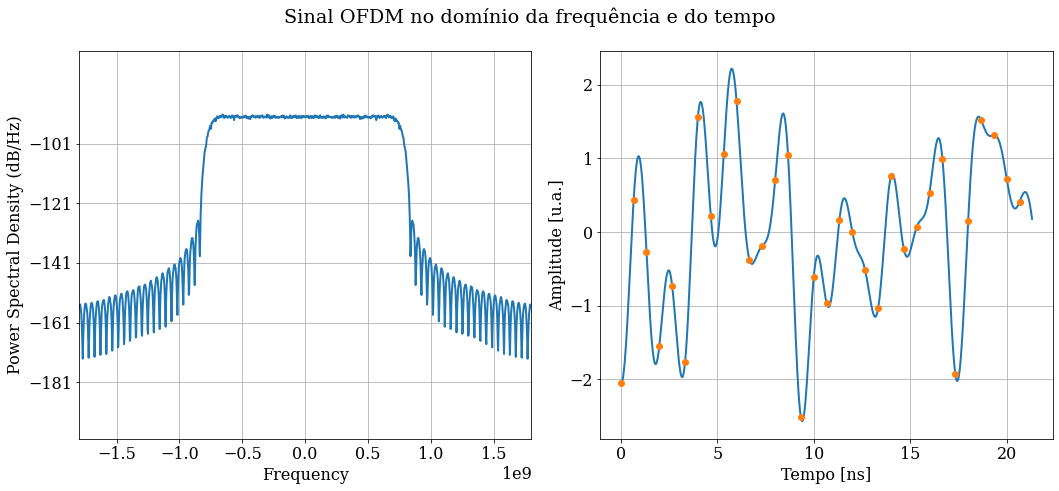

In [186]:
fig, axs = plt.subplots(1, 2, figsize=(15,7))
plt.suptitle("Sinal OFDM no domínio da frequência e do tempo")

t = np.arange(0, sigTx.size)*Ta
idX = np.arange(0, 1024)

axs[0].psd(sigTx, Fs=Fa, NFFT = 16*1024, sides='twosided')
axs[0].set_xlim(-1.2*Rs, 1.2*Rs)
axs[0].set_ylim(-200, -70)

axs[1].plot(t[idX]*1e9, sigTx[idX].real)
axs[1].set_xlabel('Tempo [ns]')
axs[1].set_ylabel('Amplitude [u.a.]')
axs[1].grid(True)

axs[1].plot(t[idX][0::SpS]*1e9, sigTx[idX][0::SpS].real,'o')

plt.tight_layout()

### 1.1 - Modulação em fase

In [187]:
H  = 0.35/(2*pi)    # Índice de modulação
fc = 1e9            # Frequência da portadora
A  = 1              # Amplitude da portadora

sigTx_CE = A*np.cos(2*pi*fc*t + 2*pi*H*sigTx)

PAPR = 3.01 dB


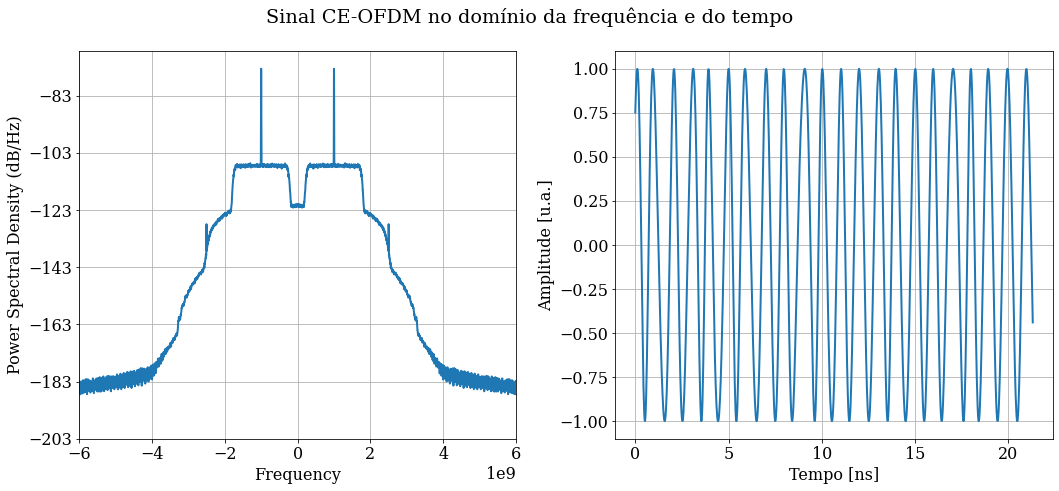

In [188]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
plt.suptitle("Sinal CE-OFDM no domínio da frequência e do tempo")

axs[0].psd(sigTx_CE, Fs=Fa, NFFT = 16*1024, sides='twosided')
axs[0].set_xlim(-4*Rs, 4*Rs)

axs[1].plot(t[idX]*1e9, sigTx_CE[idX].real)
axs[1].set_xlabel('Tempo [ns]')
axs[1].set_ylabel('Amplitude [u.a.]')
axs[1].grid()

plt.tight_layout()

# PAPR
L = 1000
PP = max(sigTx_CE[0:L*(N+G)].real)**2/signal_power(sigTx_CE[0:L*(N+G)].real)

PAPR = 10*np.log10(PP)
print('PAPR = %.2f dB' %(PAPR))

In [189]:
# Parâmetros da fibra
paramCh = parameters()
paramCh.Ltotal = 500      # Comprimento total do link [km]
paramCh.Lspan  = 100      # Comprimento de um span de fibra [km]
paramCh.hz     = 1.0      # Comprimento do passo para o método SSF [km]
paramCh.alpha  = 0.2      # Atenuação da fibre [dB/km]
paramCh.D      = 18       # Parâmetro de dispersão cromática [ps/nm/km]
paramCh.gamma  = 1.3      # Parâmetro de não-linearidade da fibra [1/W/km]
paramCh.Fc     = 193.4e12 # Frequência da portadora óptica [Hz]
paramCh.amp    = 'edfa'   # Tipo de amplificador
paramCh.NF     = 5        # Figura de ruído do amplificador [dB]

# Parâmetros do MZM
Vπ = 3
Vb = -0.5*Vπ

Pi_dBm = 5                     # Potência de sinal óptico na entrada do modulador em dBm
Pi     = 10**(Pi_dBm/10)*1e-3  # Potência de sinal óptico em W na entrada do MZM

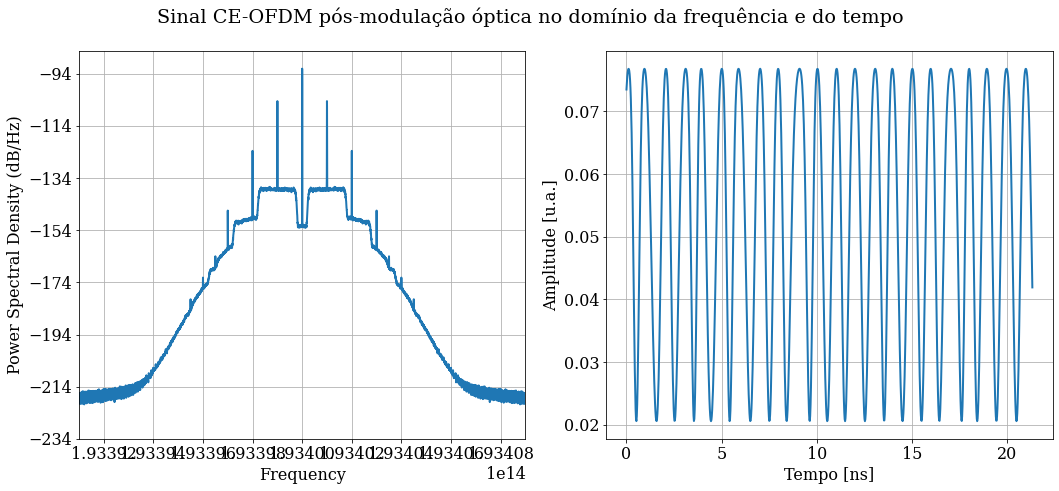

In [190]:
# Modulação óptica
Ai     = np.sqrt(2*Pi)
sigTxo = mzm(Ai, Vπ, sigTx_CE, Vb)

fig, axs = plt.subplots(1, 2, figsize=(15, 7))
plt.suptitle("Sinal CE-OFDM pós-modulação óptica no domínio da frequência e do tempo")

axs[0].psd(sigTxo, Fs=Fa, NFFT = 16*1024, sides='twosided', Fc = paramCh.Fc)
axs[0].set_xlim(-6*Rs + paramCh.Fc, 6*Rs + paramCh.Fc)

axs[1].plot(t[idX]*1e9, sigTxo[idX].real)
axs[1].set_xlabel("Tempo [ns]")
axs[1].set_ylabel("Amplitude [u.a.]")
axs[1].grid(True)

plt.tight_layout()

## 2 - Canal Óptico

In [191]:
NFFT      = len(sigTxo)
sigTxoFFT = fftshift(fft(sigTxo))/NFFT
sigTxoPx  = np.abs(sigTxoFFT)**2
freq      = fftshift(fftfreq(len(sigTxoFFT), Ta))

# Solução da NLSE pelo método SSF
sigRxo,_  = ssfm(sigTxo, Fa, paramCh)

sigRxoFFT = fftshift(fft(sigRxo))/NFFT
sigRxoPx  = np.abs(sigRxoFFT)**2

  0%|          | 0/5 [00:00<?, ?it/s]

Potência do sinal Tx (em dBm) = 5.00 dBm
Potência do sinal Rx (em dBm) = 5.01 dBm


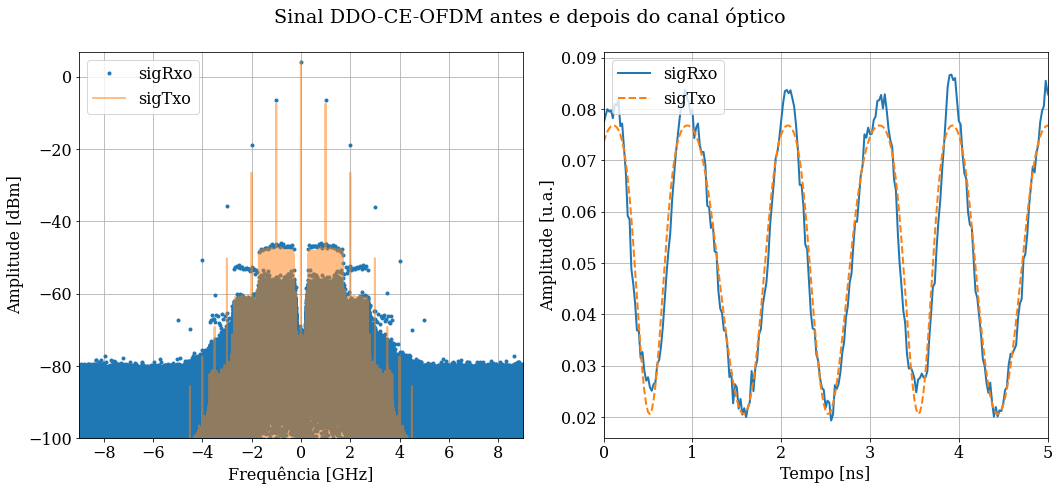

In [192]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
plt.suptitle("Sinal DDO-CE-OFDM antes e depois do canal óptico")

axs[0].plot(1e-9*freq, 10*np.log10(1e3*sigRxoPx), '.', label = 'sigRxo')
axs[0].plot(1e-9*freq, 10*np.log10(1e3*sigTxoPx), alpha = 0.5, label = 'sigTxo')
axs[0].set_ylabel("Amplitude [dBm]")
axs[0].set_xlabel("Frequência [GHz]")
axs[0].set_xlim(-6e-9*Rs, 6e-9*Rs)
axs[0].set_ylim(-100, Pi_dBm + 2)
axs[0].grid()
axs[0].legend(loc = 'upper left')

axs[1].plot(t[idX]*1e9, abs(sigRxo)[idX], label = 'sigRxo')
axs[1].plot(t[idX]*1e9, abs(sigTxo)[idX], '--', label = 'sigTxo')
axs[1].set_xlabel("Tempo [ns]")
axs[1].set_xlim(0, 5)
axs[1].set_ylabel("Amplitude [u.a.]")
axs[1].grid()
axs[1].legend(loc = 'upper left')

plt.tight_layout()

print('Potência do sinal Tx (em dBm) = %.2f dBm' %(10*np.log10(signal_power(sigTxo)*1000)))
print('Potência do sinal Rx (em dBm) = %.2f dBm' %(10*np.log10(signal_power(sigRxo)*1000)))

## 3 - Recepção

In [193]:
# Parâmetros do receptor
Tc  = 25        # Temperatura [°C]
Rd  = 0.85      # Responsividade [A/W]
Id  = 5e-9      # Corrente de escuro [A]
RL  = 50        # Resistência [Ω]
B   = 10e9      # Banda do receptor [Hz]

In [194]:
Pin = (np.abs(sigRxo)**2).mean()   # Potência óptica média recebida
Ip  = Rd*np.abs(sigRxo)**2         # Fotocorrente livre de ruído do receptor

# Ruído de disparo 
σ2_s = 2*e*(Rd*Pin + Id)*B         # Variância do ruído de disparo 

# Ruído térmico
T    = Tc + 273.15                 # Temperatura em Kelvin
σ2_T = 4*k*T*B/RL                  # Variância do ruído térmico

# Adiciona ruído do receptor p-i-n aos sinais
Is = normal(0, np.sqrt(Fa*(σ2_s/(2*B))), Ip.size)
It = normal(0, np.sqrt(Fa*(σ2_T/(2*B))), Ip.size)  

I = Ip + Is + It

# FPB (Resposta do fotodetector)
I_Rx = firFilter(lowPassFIR(B, Fa, 8000, 'rect'), I)

# FPA (Retirada do nível DC)
I_Rx = firFilter(highPassFIR(0.1e9, Fa, 8001), I_Rx)

### 3.1 - Extração da fase

A demodulação de fase pode ser feita, pelo menos, de duas maneiras. A primeira faz uso da estrutura ilustrada abaixo, já o segundo método aproveita as propriedades da transformada de Hilbert para extrair a fase do sinal.

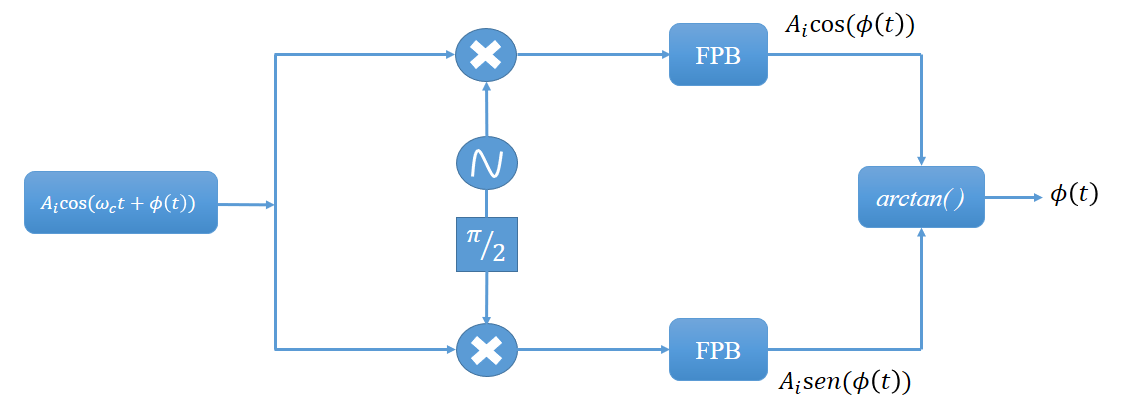

In [195]:
# Extração da fase
I1 = firFilter(pulse/SpS, I*np.sin(2*pi*fc*t))
I2 = firFilter(pulse/SpS, I*np.cos(2*pi*fc*t))

Φ = -np.unwrap(np.arctan(I1/I2))/(2*pi*H)

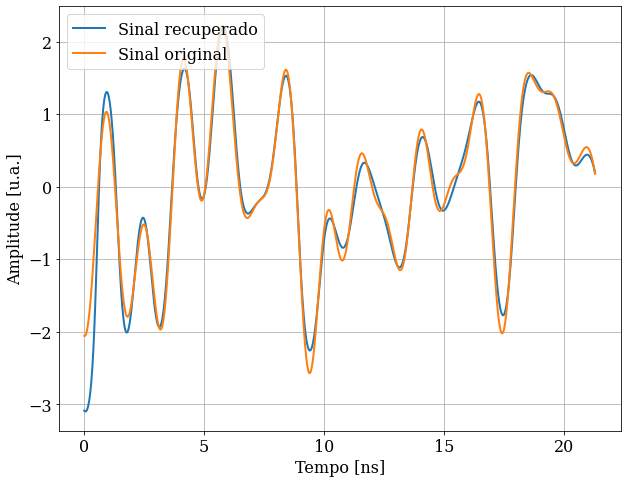

In [196]:
plt.figure(figsize = (9, 7))
plt.plot(t[idX]*1e9, Φ[idX], label = 'Sinal recuperado')
plt.plot(t[idX]*1e9, sigTx[idX].real, label = 'Sinal original')
plt.legend(loc = 'upper left')
plt.xlabel('Tempo [ns]')
plt.ylabel('Amplitude [u.a.]')
plt.grid()
plt.tight_layout()

O método de demodulação de fase empregado no artigo faz uso da transformada de Hilbert para obter a forma analítica do sinal de corrente ($i_a = i_{pin} + j\hat{i}_{pin}$), depois multiplica-o pela exponencial complexa, como ilustrado abaixo:

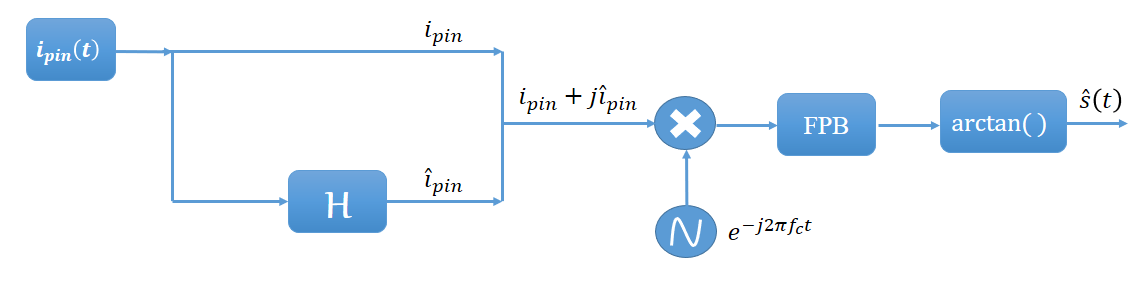

Sabendo que para $\omega >> \phi(t)$, a seguinte propriedade é válida: $\mathcal{H}\{A\cos(\omega t + \phi(t))\} \approx A\sin(\omega t + \phi(t))$, logo, antes do filtro passa-baixa, o sinal da corrente tem a seguinte forma:

$$
\begin{align*}
    i(t) &= (i_{pin} + j\hat{i}_{pin})\cdot e^{-j\omega_c t} = (K_1\cos(\omega_c t + s(t)) + K_2(t)n_i(t)) + j(K_1\sin(\omega_c t + s(t)) + \mathcal{H}\{K_2(t)n_i(t)\} ) \cdot e^{-j\omega_c t} \\
    & = K_1\cos(\omega_c t + s(t))\cos(\omega_c t) + K_2(t)n_i(t)\cos(\omega_c t) + K_1\sin(\omega_c t + s(t))\sin(\omega_c t) + \mathcal{H}\{K_2(t)n_i(t)\}\sin(\omega_c t) + \\
    & + j( -K_1\cos(\omega_c t + s(t))\sin(\omega_c t) - K_2(t)n_i(t))\sin(\omega_c t) + K_1\sin(\omega_c t + s(t))\cos(\omega_c t) + \mathcal{H}\{K_2(t)n_i(t)\}\cos(\omega_c t) ) \\
    & = \dfrac{K_1}{2}\cos(s(t)) + \dfrac{K_1}{2}\cos(2\omega_c t + s(t)) + K_2(t)n_i(t)\cos(\omega_c t) + \dfrac{K_1}{2}\cos(s(t)) - \dfrac{K_1}{2}\cos(2\omega_c t + s(t)) + \mathcal{H}\{K_2(t)n_i(t)\}\sin(\omega_c t) + \\
    & + j\left( \dfrac{K_1}{2}\sin(s(t)) - \dfrac{K_1}{2}\sin(2\omega_c t + s(t)) - K_2(t)n_i(t))\sin(\omega_c t) + \dfrac{K_1}{2}\sin(s(t)) + \dfrac{K_1}{2}\sin(2\omega_c t + s(t)) + \mathcal{H}\{K_2(t)n_i(t)\}\cos(\omega_c t) \right)
\end{align*}
$$

Substituindo $s(t) = 2\pi hx(t)$ e reorganizando os termos, $i(t)$ é:

$$
\begin{align*}
i(t) &= D(t) + jN(t) \\
&= K_1\cos(2\pi hx(t)) + K_2(t)n_i(t)\cos(\omega_c t) + \mathcal{H}\{K_2(t)n_i(t)\}\sin(\omega_c t) + j\left( K_1\sin(2\pi hx(t)) -K_2(t)n_i(t)\sin(\omega_c t) + \mathcal{H}\{K_2(t)n_i(t)\}\cos(\omega_c t) \right)
\end{align*}
$$

Após isso, o sinal passa por filtro casado passa-baixa, e então aplica-se o operador $arctan( )$:

$$
\hat{s}(t) = arctan\left(\dfrac{N(t)}{D(t)}\right)
$$

In [197]:
signal_a = firFilter(pulse/SpS, hilbert(I_Rx) * np.exp(-1j*2*pi*fc*t))
Θ = np.unwrap(np.arctan(signal_a.imag/signal_a.real))/(2*pi*H)

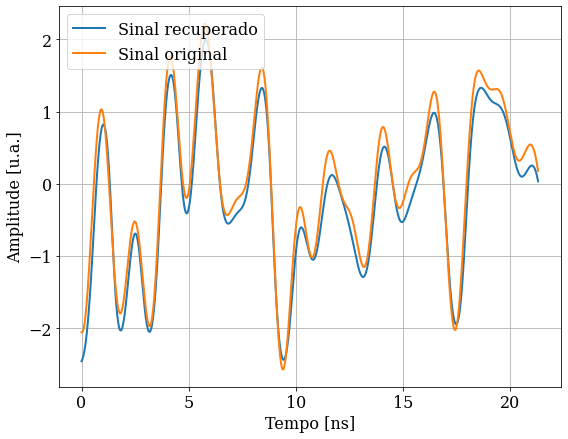

In [198]:
plt.figure(figsize = (9, 7))
plt.plot(t[idX]*1e9, Θ[idX], label = 'Sinal recuperado')
plt.plot(t[idX]*1e9, sigTx[idX].real, label = 'Sinal original')
plt.legend(loc = 'upper left')
plt.xlabel('Tempo [ns]')
plt.ylabel('Amplitude [u.a.]')
plt.grid()

### 3.2 - Demodulação dos símbolos OFDM

In [201]:
# Seleção das amostras do sinal recebido
symbRx_OFDM = Θ[0::SpS]

# Demodulação OFDM
symbRx = demodulateOFDM(N, G, K, pilot, symbRx_OFDM)

symbRx[0::int(N/2)] = 'nan'
symbTx[0::int(N/2)] = 'nan'

symbTx = symbTx[~np.isnan(symbTx)]
symbRx = symbRx[~np.isnan(symbRx)]

# Cálculo da BER
fastBERcalc(symbRx, symbTx, M, 'qam')

(array([0.00046885]), array([0.00187541]), array([19.78984234]))

(-1.5, 1.5)

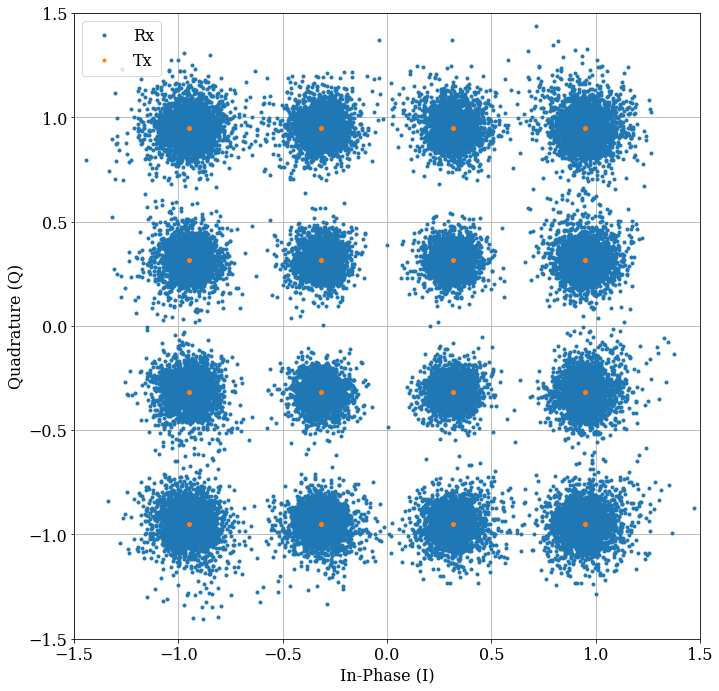

In [202]:
# Plot da constelação transmitida e recebida
plt.figure(figsize=(10, 10))
plt.plot(symbRx.real, symbRx.imag, '.', label = 'Rx')
plt.plot(symbTx.real, symbTx.imag, '.', label = 'Tx')
plt.axis('square')
plt.xlabel('In-Phase (I)')
plt.ylabel('Quadrature (Q)')
plt.legend(loc = 'upper left')
plt.tight_layout()
plt.grid()

plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)